## Load Data

In [1]:
import re
import os
import pandas as pd

regex = re.compile(r'\[.+\]\n', re.IGNORECASE)
file_paths, file_names, sessions, emotions = [], [], [], []
emotion_map = {'neu': 'neutral', 'ang': 'angry', 'hap': 'happy', 'exc': 'happy', 'sad': 'sad'}

for session in range(1, 6):
    emo_evaluation_dir = f'/home/jz3313/IEMOCAP_full_release/Session{session}/dialog/EmoEvaluation/'
    file_dir = f'/home/jz3313/IEMOCAP_full_release/Session{session}/sentences/wav/'
    evaluation_files = [l for l in os.listdir(emo_evaluation_dir) if 'Ses' in l]
    for file in evaluation_files:
        with open(emo_evaluation_dir + file) as f:
            content = f.read()
        lines = re.findall(regex, content)
        for line in lines[1:]:  # the first line is a header
            start_end_time, wav_file_name, emotion, val_act_dom = line.strip().split('\t')
            dir_name = '_'.join(wav_file_name.split('_')[:-1])
            if emotion in emotion_map:
                file_paths.append(file_dir+dir_name+'/'+wav_file_name+'.wav')
                file_names.append(wav_file_name)
                sessions.append(session)
                emotions.append(emotion_map[emotion])

In [2]:
file = pd.DataFrame({'path':file_paths, 'name': file_names, 'session': sessions, 'emotion': emotions})
file['newpath'] = file.apply(lambda x: f'../data/wav2vecbase/Session{x[2]}/{x[1]}.pt', axis=1)
file.head()

,path,name,session,emotion,newpath
0,/home/jz3313/IEMOCAP_full_release/Session1/sen...,Ses01F_impro02_F000,1,sad,../data/wav2vecbase/Session1/Ses01F_impro02_F0...
1,/home/jz3313/IEMOCAP_full_release/Session1/sen...,Ses01F_impro02_F001,1,sad,../data/wav2vecbase/Session1/Ses01F_impro02_F0...
2,/home/jz3313/IEMOCAP_full_release/Session1/sen...,Ses01F_impro02_F002,1,sad,../data/wav2vecbase/Session1/Ses01F_impro02_F0...
3,/home/jz3313/IEMOCAP_full_release/Session1/sen...,Ses01F_impro02_F003,1,neutral,../data/wav2vecbase/Session1/Ses01F_impro02_F0...
4,/home/jz3313/IEMOCAP_full_release/Session1/sen...,Ses01F_impro02_F004,1,sad,../data/wav2vecbase/Session1/Ses01F_impro02_F0...


In [4]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

1.12.1+cu113
0.12.1+cu113
cuda


In [9]:
from tqdm import tqdm

holdout = 1
train_audios = []
test_audios = []
train_emotions = []
test_emotions = []

for _, row in tqdm(file.iterrows()):
    audio = torch.load(row[4])
    audio = torch.mean(audio, dim=1, keepdim=False)
    emotion = row[3]
    if row[2] != holdout:
        train_audios.append(audio)
        train_emotions.append(emotion)
    else:
        test_audios.append(audio)
        test_emotions.append(emotion)
    

5531it [00:24, 226.98it/s]


In [20]:
class MyDataSet(torch.utils.data.Dataset):
    def __init__(self, datas, labels, label_transform):
        super(MyDataSet).__init__()
        self.datas = datas
        self.labels = labels
        self.label_transform = label_transform
        
    def __getitem__(self, idx):
        audio = self.datas[idx]
        label = self.label_transform[self.labels[idx]]
        return audio, label
    
    def __len__(self):
        return len(self.labels)

In [11]:
categories = ['angry', 'happy', 'neutral', 'sad']
cate_dic = {}
for i, cate in enumerate(categories):
    cate_dic[cate] = i
cate_dic

{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3}

## Model

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class NN(nn.Module):
    def __init__(self, vocab_size, hidden_size=128, label_size=7):
        super().__init__()
        self.nn = nn.Linear(in_features = vocab_size, out_features = hidden_size)
        self.linear = nn.Linear(in_features = hidden_size, out_features = label_size)

    def forward(self, x):
        x = self.nn(x)
        logits = self.linear(x)
        return logits

In [38]:
from torch.utils.data import DataLoader
import torch.optim as optim

layers = 12
test_accuracies = []
for layer in range(layers):
    train = torch.stack([x[layer] for x in train_audios])
    test = torch.stack([x[layer] for x in test_audios])
    train_dataset = MyDataSet(train, train_emotions, cate_dic)
    trainloader_args = dict(batch_size=64, shuffle=True)
    train_dataloader = DataLoader(train_dataset, **trainloader_args)
    
    model = NN(768, 128, 4)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    epochs = 80
    
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    for epoch in tqdm(range(epochs)):
        train_loss = 0
        acc_cnt = 0
        err_cnt = 0
        batch_cnt = 0
        model.train()
        for batch, (x, y) in enumerate(train_dataloader):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.cpu().item()

            #model outputs
            out_val, out_indices = torch.max(logits, dim=1)
            tar_indices = y

            for i in range(len(out_indices)):
                if out_indices[i] == tar_indices[i]:
                    acc_cnt += 1
                else:
                    err_cnt += 1
            batch_cnt += 1

        train_loss = train_loss/batch_cnt
        train_accuracy = acc_cnt/(acc_cnt+err_cnt)
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)
        
    test_dataset = MyDataSet(test, test_emotions, cate_dic)
    testloader_args = dict(batch_size=1, shuffle=True)
    test_dataloader = DataLoader(test_dataset, **testloader_args)

    test_loss = 0
    acc_cnt = 0
    err_cnt = 0
    batch_cnt = 0
    model.eval()

    for x, y in test_dataloader:

        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        loss = criterion(logits, y)
        test_loss += loss.cpu().item()

        out_val, out_indices = torch.max(logits, dim=1)
        tar_indices = y

        for i in range(len(out_indices)):
            if out_indices[i] == tar_indices[i]:
                acc_cnt += 1
            else:
                err_cnt += 1
        batch_cnt += 1

    test_loss = test_loss/batch_cnt
    test_accuracy = acc_cnt/(acc_cnt+err_cnt)
    print(f'layer: {layer}, test accuracy: {test_accuracy}')
    test_accuracies.append(test_accuracy)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:46<00:00,  1.73it/s]


layer: 0, test accuracy: 0.6138248847926268


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:43<00:00,  1.83it/s]


layer: 1, test accuracy: 0.576036866359447


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:43<00:00,  1.82it/s]


layer: 2, test accuracy: 0.5576036866359447


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:38<00:00,  2.06it/s]


layer: 3, test accuracy: 0.5502304147465438


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:21<00:00,  3.78it/s]


layer: 4, test accuracy: 0.6341013824884792


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:20<00:00,  3.96it/s]


layer: 5, test accuracy: 0.6138248847926268


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:20<00:00,  3.91it/s]


layer: 6, test accuracy: 0.6248847926267281


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:20<00:00,  3.81it/s]


layer: 7, test accuracy: 0.6129032258064516


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:20<00:00,  3.91it/s]


layer: 8, test accuracy: 0.576036866359447


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:21<00:00,  3.71it/s]


layer: 9, test accuracy: 0.6027649769585254


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:46<00:00,  1.71it/s]


layer: 10, test accuracy: 0.5493087557603686


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:21<00:00,  3.80it/s]


layer: 11, test accuracy: 0.5741935483870968


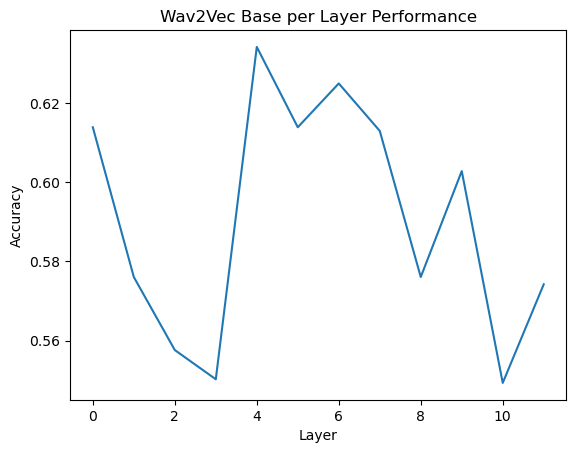

In [41]:
import matplotlib.pyplot as plt

plt.plot(range(layers), test_accuracies)
plt.xlabel("Layer")
plt.ylabel("Accuracy")
plt.title("Wav2Vec Base per Layer Performance")
plt.show()